In [546]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import wave
import pickle as pkl
import pyaudio

In [547]:
file = '../groovemidi_beatnet_data.pkl'
with open(file,'rb') as f:
    data = pkl.load(f)


In [548]:
import pyaudio
def play_audio(file,seconds_to_play=-1):

    audio = wave.open(file,'rb')

    chunk = 1024
    # create an audio object
    p = pyaudio.PyAudio()

    # open stream based on the wave object which has been input.
    stream = p.open(format =
                    p.get_format_from_width(audio.getsampwidth()),
                    channels = audio.getnchannels(),
                    rate = audio.getframerate(),
                    output = True)

    frames_to_play = audio.getnframes()
    if seconds_to_play != -1:
        frames_to_play = int(audio.getframerate() * seconds_to_play)

    # read data (based on the chunk size)
    data = audio.readframes(chunk)

    # play stream (looping from beginning of file to the end)
    frames_played = chunk
    while data and frames_played < frames_to_play:
        # writing to the stream is what *actually* plays the sound.
        stream.write(data)
        data = audio.readframes(chunk)
        frames_played += chunk


    # cleanup stuff.
    audio.close()
    stream.close()    
    p.terminate()

In [573]:
audio_name = 'drummer1/eval_session/1_funk-groove1_138_beat_4-4'
audio_file = 'data/'+audio_name+'.wav'
aud = wave.open(audio_file,'rb')
aud_beats = data["groove-midi/"+audio_name]

In [574]:
print(aud.getnframes())
aud.getnframes()/aud.getframerate() # total secs of audio

1227131


27.826099773242632

In [575]:
aud = wave.open(audio_file,mode='rb')
fr = aud.getframerate()
nf = aud.getnframes()
sig = aud.readframes(-1)

In [576]:
sig = np.fromstring(sig, np.int16)
sig = np.int64(sig)
sig_channel_1 = sig[::2]
sig_channel_2 = sig[1::2]

/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_59768/426249249.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  sig = np.fromstring(sig, np.int16)


In [577]:
nf

1227131

In [578]:
play_audio(audio_file,seconds_to_play=11.5)

KeyboardInterrupt: 

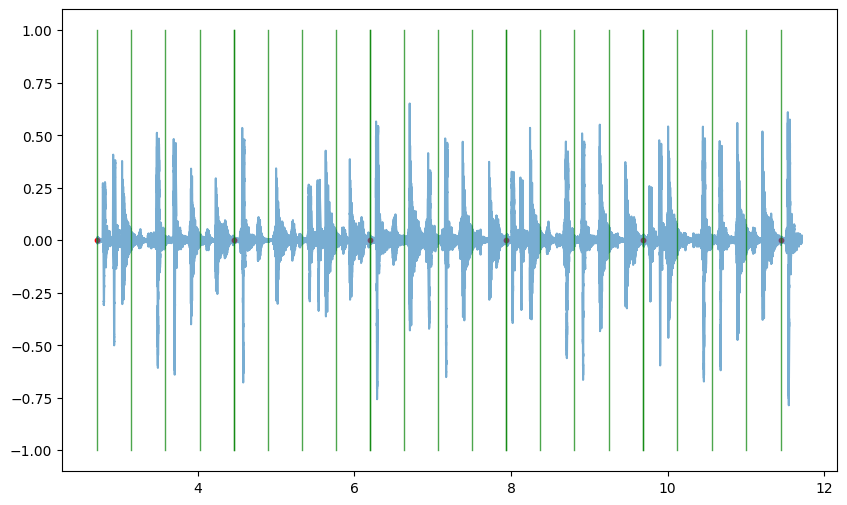

In [579]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

dbeats = aud_beats[aud_beats[:,1]==1,0]

bar_interval = (1,6)
num_bar_to_plot = bar_interval[1] - bar_interval[0]

time_to_plot = dbeats[bar_interval[1]] - dbeats[bar_interval[0]] + 1/fr #second
frames_to_plot = round(time_to_plot * fr)
frame_interval = [int(dbeats[bar_interval[0]] * fr), int(dbeats[bar_interval[1]] * fr) + 12024]
if bar_interval[0] == 0:
    frame_interval[0] = 0
xdata = np.arange(*frame_interval)/fr

ax.scatter(dbeats[bar_interval[0]:bar_interval[1]+1],[0]*(num_bar_to_plot+1),color='red',s=10)
ax.plot(xdata,sig_channel_1[frame_interval[0]:frame_interval[1]]/max(abs(sig_channel_1)),alpha=0.6)

for n in range(*bar_interval):
    sub_beats = np.linspace(dbeats[n],dbeats[n+1],5)
    interval = sub_beats[1] - sub_beats[0] 
    # print(interval*fr)
    for x in sub_beats:
        # for debugging
        # print(x*fr)
        # print(np.sum(sig_channel_1[int((x-interval)*fr):int((x+interval)*fr)]**2)/max(sig_channel_1**2))
        
        ax.plot([x,x],[-1,1],color='g',lw=1,alpha=0.7)

In [538]:
dbeats[:5]

array([1.2 , 2.26, 3.3 , 4.4 , 5.52])

In [527]:
time_to_plot

np.float64(2.100022675736961)

Doing naive embedding

In [528]:
def bar_embedding(data,dbeats,bar_num,dimension,framerate,kernel=None, kernel_width=None):
    assert bar_num < len(dbeats), 'bar_num must be smaller than the number of bars in the audio'

    time_interval = (dbeats[bar_num-1],dbeats[bar_num])
    frame_interval = (int(time_interval[0]*framerate), int(time_interval[1]*framerate))

    sub_beats = np.round(np.linspace(frame_interval[0],frame_interval[1],dimension+1))
    sub_beat_interval = int(sub_beats[1] - sub_beats[0])

    if not kernel:
        if not kernel_width:
            kernel_width = 1
        kernel_sigma = kernel_width*sub_beat_interval
        kernel = np.exp(-np.arange(-sub_beat_interval,sub_beat_interval,1)**2/(2*kernel_sigma**2))
        kernel = kernel / np.sum(kernel)
    # print(kernel.shape)

    
    sub_beat_data = [0]*(dimension) # we do not want to count down beat twice
    for i in range(dimension-1):
        # getting data around subbeat[i] of length 2*sub_beat_length
        # print(sub_beats[i])
        start = int(sub_beats[i]-sub_beat_interval)
        end = int(sub_beats[i]+sub_beat_interval)
        sub_data = np.zeros(2*sub_beat_interval)
        # print(sub_data.shape)
        # print(start,end)
        if start < 0:
            sub_data[-start:] = data[0:end]
        elif end > len(data):
            sub_data[:len(data)-end] = data[start:]
        else:
            sub_data = data[start:end]

        sub_data = sub_data**2
        # print(np.sum(sub_data),np.sum(kernel))
        sub_beat_data[i] = np.sum(kernel*(sub_data))

    return sub_beat_data 





In [531]:
sub_beat_data = []
division=8
for bar_num in range(1,len(dbeats)):
    # print(bar_num)
    sub_beat_data.append(bar_embedding(sig_channel_1/max(abs(sig_channel_1)),dbeats,bar_num=bar_num,dimension=division,framerate=fr,kernel_width=1/4))

[np.float64(0.05016383854412799),
 np.float64(0.00043150461079547733),
 np.float64(2.341209156514771e-05),
 np.float64(0.00015199752311205982),
 np.float64(0.06104502494476987),
 np.float64(0.020112156698433564),
 np.float64(0.0008306671266702692),
 0]

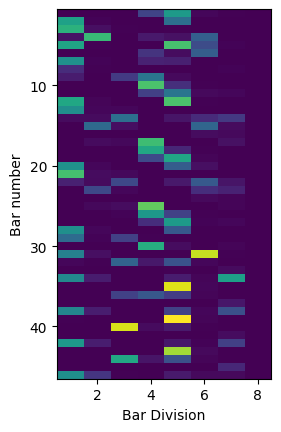

In [534]:
fig,ax = plt.subplots(1,1)
ax.imshow(sub_beat_data,extent=[1-0.5,len(sub_beat_data[0])+0.5,len(sub_beat_data)+0.5,0.5],interpolation='none',aspect=0.3)
ax.set_xlabel('Bar Division')
ax.set_ylabel('Bar number')
sub_beat_data[4]

[[<matplotlib.lines.Line2D at 0x304800040>],

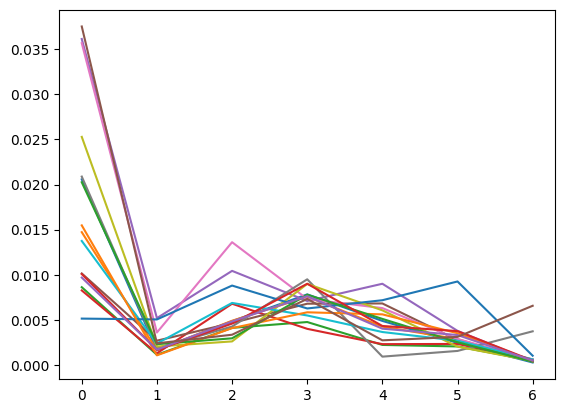

In [472]:
[plt.plot(x) for x in sub_beat_data]

In [358]:
32392**2

1049241664

In [348]:
a = np.abs(sig_channel_1)
b = sig_channel_1**2
max(a**2), max(a)**2

(np.int16(32761), np.int16(10304))

In [411]:
bar_embedding(sig_channel_1/max(abs(sig_channel_1)),dbeats,bar_num=4+1,dimension=8,framerate=fr)

(28980,)
365.42281904943485 1.0000000000000002
770.3008346340315 1.0000000000000002
413.9087376280551 1.0000000000000002
90.59870049632342 1.0000000000000002
247.32370739711686 1.0000000000000002
211.10673669645664 1.0000000000000002
71.82514229534064 1.0000000000000002
111.86487010393822 1.0000000000000002


[np.float64(0.014603356086556324),
 np.float64(0.023910283676418242),
 np.float64(0.014999757710764608),
 np.float64(0.00354099523060858),
 np.float64(0.008621300207840583),
 np.float64(0.006999206758095124),
 np.float64(0.0022570314433889766),
 np.float64(0.004411624791591383)]

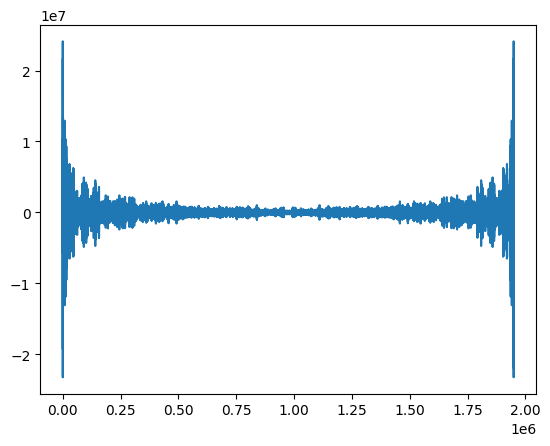

In [562]:
plt.plot(np.fft.fft(sig_channel_1)[10000:-10000])

In [564]:
aa = np.zeros(32)
aa[-1] = 28
np.std(aa)*5000

np.float64(4.871793817476269)

In [565]:
5000**0.5

70.71067811865476